<a href="https://colab.research.google.com/github/rashmikaks/RailwayTrackFaultDectection/blob/main/Railway.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 2: Install Required Libraries
!pip install torch torchvision torchaudio opencv-python numpy pandas matplotlib scikit-learn albumentations flask streamlit ultralytics

In [ ]:
# Step 3: Define Dataset Path
import os

dataset_path = "/content/drive/MyDrive/ML/railway_dataset/"
if os.path.exists(dataset_path):
    print("Dataset found!")
else:
    print("Dataset path is incorrect. Check and update the path.")

Dataset found!


In [ ]:
# Step 4: Image Preprocessing and Augmentation
import cv2
import numpy as np
import albumentations as A
import torch
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# Preprocessing Function
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    # Data Augmentation
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.GaussNoise(p=0.2)
    ])
    augmented = transform(image=image)
    image = augmented['image']

    # Normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = transform(Image.fromarray(image))

    return image

# Process entire dataset
def preprocess_dataset(dataset_folder):
    for category in ["defective", "non_defective"]:
        folder_path = os.path.join(dataset_folder, category)
        for img_name in tqdm(os.listdir(folder_path), desc=f"Processing {category} images"):
            img_path = os.path.join(folder_path, img_name)
            preprocess_image(img_path)

# Apply preprocessing
preprocess_dataset(os.path.join(dataset_path, "train"))
preprocess_dataset(os.path.join(dataset_path, "valid"))
preprocess_dataset(os.path.join(dataset_path, "test"))


Processing non_defective images: 100%|██████████| 11/11 [00:00<00:00, 81.26it/s]


In [ ]:
# Step 5: Visualize Preprocessed Images

import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image


# Function to Display Original & Processed Image
def visualize_preprocessing(dataset_folder, category):
    image_folder = os.path.join(dataset_folder, category)

    # Check if the folder exists
    if not os.path.exists(image_folder):
        print(f"Error: Folder {image_folder} does not exist!")
        return

    image_name = random.choice(os.listdir(image_folder))
    image_path = os.path.join(image_folder, image_name)

    # Load Original Image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Processed Image
    processed_image = preprocess_image(image_path).permute(1, 2, 0).numpy()  # Convert tensor to numpy

    # Display Images
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(1,2,2)
    plt.imshow(processed_image)
    plt.title("Preprocessed Image")

    plt.show()

# Test Visualization (Ensure Correct Dataset Path)
visualize_preprocessing(os.path.join(dataset_path, "train"), "defective")
visualize_preprocessing(os.path.join(dataset_path, "train"), "non_defective")


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
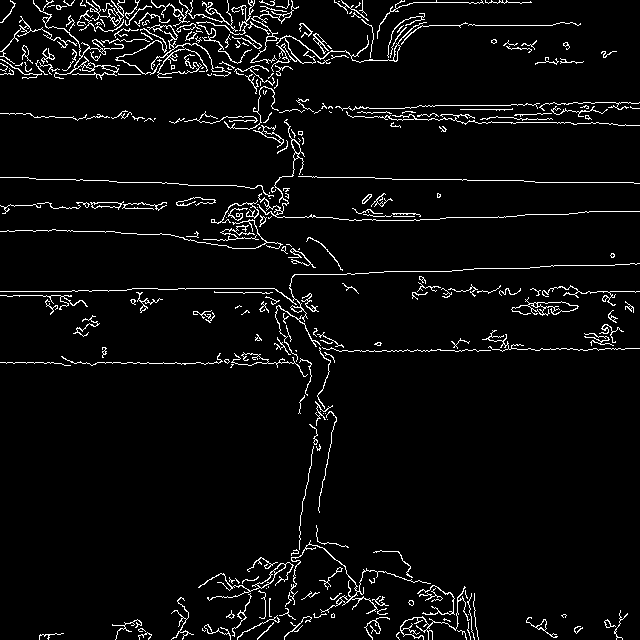

In [ ]:
# Step 6: Canny Edge Detection
import matplotlib.pyplot as plt

def canny_edge_detection(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(image, threshold1=50, threshold2=150)

    # Display Original & Edge Image
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")

    plt.subplot(1,2,2)
    plt.imshow(edges, cmap='gray')
    plt.title("Canny Edge Detection")

    plt.show()
    return edges

# Test on a sample image
sample_image = os.path.join(dataset_path, "train/defective", os.listdir(os.path.join(dataset_path, "train/defective"))[0])
canny_edge_detection(sample_image)


In [ ]:
# Step 7: Load Pretrained ResNet50
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

resnet50 = models.resnet50(pretrained=True)
resnet50.eval()  # Evaluation mode

# Feature Extraction Function (TRUE deep features)
def extract_cnn_features(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5])
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)

    with torch.no_grad():
        x = resnet50.conv1(image)
        x = resnet50.bn1(x)
        x = resnet50.relu(x)
        x = resnet50.maxpool(x)

        x = resnet50.layer1(x)
        x = resnet50.layer2(x)
        x = resnet50.layer3(x)
        x = resnet50.layer4(x)

        x = resnet50.avgpool(x)
        features = torch.flatten(x, 1)

    return features

# Test Feature Extraction
features = extract_cnn_features(sample_image)
print(f"Extracted Features Shape: {features.shape}")


Extracted Features Shape: torch.Size([1, 2048])


In [ ]:
# Step 8: Modify ResNet-50 for Binary Classification
import torch.nn as nn
import torch.optim as optim

# Modify ResNet-18 for binary classification (Defective / Non-Defective)
class RailwayTrackClassifier(nn.Module):
    def __init__(self):
        super(RailwayTrackClassifier, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(2048, 2)  # 2 Classes (Defective, Non-Defective)

    def forward(self, x):
        return self.model(x)

# Instantiate Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res_model = RailwayTrackClassifier().to(device)


In [ ]:
# Step 9: Load Data using DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define Image Transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load Train, Validation, and Test Data
train_data = ImageFolder(root=os.path.join(dataset_path, "train"), transform=train_transform)
valid_data = ImageFolder(root=os.path.join(dataset_path, "valid"), transform=train_transform)
test_data = ImageFolder(root=os.path.join(dataset_path, "test"), transform=train_transform)

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Train Samples: {len(train_data)}, Validation Samples: {len(valid_data)}, Test Samples: {len(test_data)}")


Train Samples: 300, Validation Samples: 62, Test Samples: 22


In [ ]:
# Step 10: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(res_model.parameters(), lr=0.0001)

In [ ]:
# Step 11: Train the ResNet-50 Classification Model with Early Stopping

def train_model(res_model, train_loader, valid_loader, max_epochs=20, patience=3):

    optimizer = optim.Adam(res_model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(max_epochs):
        # ---------- Training ----------
        res_model.train()
        total_loss, correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = res_model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_data)

        # ---------- Validation ----------
        res_model.eval()
        correct = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = res_model(images)
                correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = correct / len(valid_data)

        print(f"Epoch [{epoch+1}] | "
              f"Loss: {total_loss:.4f} | "
              f"Train Acc: {train_acc:.4f} | "
              f"Val Acc: {val_acc:.4f}")

        # ---------- Early Stopping ----------
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(res_model.state_dict(), "best_resnet_model.pth")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            print(f"Best Validation Accuracy: {best_val_acc:.4f}")
            break

    # Load best model
    res_model.load_state_dict(torch.load("best_resnet_model.pth"))
    print("Best ResNet model loaded.")

# Train Model
train_model(res_model, train_loader, valid_loader)

Epoch [1] | Loss: 5.2353 | Train Acc: 0.7267 | Val Acc: 0.5645
Epoch [2] | Loss: 1.6115 | Train Acc: 0.9367 | Val Acc: 0.6774
Epoch [3] | Loss: 0.4433 | Train Acc: 0.9933 | Val Acc: 0.6290
Epoch [4] | Loss: 0.2608 | Train Acc: 0.9933 | Val Acc: 0.8871
Epoch [5] | Loss: 0.1561 | Train Acc: 0.9967 | Val Acc: 0.9032
Epoch [6] | Loss: 0.2380 | Train Acc: 0.9967 | Val Acc: 0.9032
Epoch [7] | Loss: 0.0768 | Train Acc: 1.0000 | Val Acc: 0.8710
Epoch [8] | Loss: 0.1287 | Train Acc: 1.0000 | Val Acc: 0.9032

Early stopping at epoch 8
Best Validation Accuracy: 0.9032
Best ResNet model loaded.


In [ ]:
# Step 12: Evaluate Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(res_model, test_loader):
    res_model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = res_model(images)
            preds = outputs.argmax(1)  # Get predicted class labels

            all_labels.extend(labels.cpu().numpy())  # Store true labels
            all_preds.extend(preds.cpu().numpy())  # Store predicted labels

    # Compute Evaluation Metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Evaluate Model with Enhanced Metrics
evaluate_model(res_model, test_loader)


Test Accuracy: 0.9545
Precision: 0.9583
Recall: 0.9545
F1-Score: 0.9545


In [ ]:
# Step 12: Evaluate Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(res_model, test_loader):
    res_model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = res_model(images)
            preds = outputs.argmax(1)  # Get predicted class labels

            all_labels.extend(labels.cpu().numpy())  # Store true labels
            all_preds.extend(preds.cpu().numpy())  # Store predicted labels

    # Compute Evaluation Metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Evaluate Model with Enhanced Metrics
evaluate_model(res_model, test_loader)


Test Accuracy: 0.9091
Precision: 0.9231
Recall: 0.9091
F1-Score: 0.9083


Upload a railway track image for ResNet classification:


Saving IMG_20201114_102945.jpg to IMG_20201114_102945.jpg


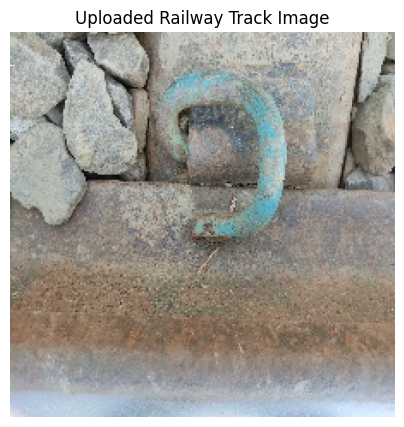

The uploaded image is classified as: "NON_DEFECTIVE"


In [ ]:
# Step 13: Upload and Process Image for Classification

from google.colab import files
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Upload image
print("Upload a railway track image for ResNet classification:")
uploaded = files.upload()
res_image_path = list(uploaded.keys())[0]

# Load image
image = Image.open(res_image_path).convert('RGB')

# Display image
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.title("Uploaded Railway Track Image")
plt.show()

# Define transform (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Preprocess image
input_tensor = transform(image).unsqueeze(0).to(device)

# Predict
res_model.eval()
with torch.no_grad():
    output = res_model(input_tensor)
    predicted_class = output.argmax(1).item()

# Class labels
class_names = ["defective", "non_defective"]

# Display result
print(f"The uploaded image is classified as: \"{class_names[predicted_class].upper()}\"")


Upload a railway track image for ResNet classification:


Saving 2007.05.16_-_002_Broken_rail_weld_-_Flickr_-_faxepl (1).jpg to 2007.05.16_-_002_Broken_rail_weld_-_Flickr_-_faxepl (1).jpg


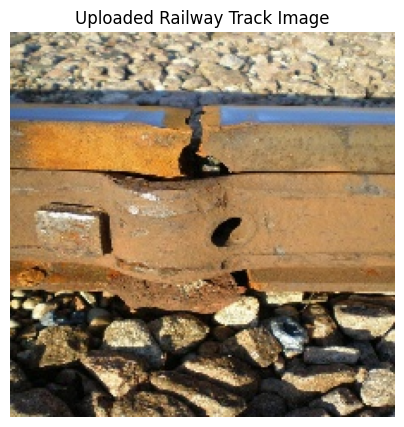

The uploaded image is classified as: "DEFECTIVE"


In [ ]:
# Step 13: Upload and Process Image for Classification

from google.colab import files
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Upload image
print("Upload a railway track image for ResNet classification:")
uploaded = files.upload()
res_image_path = list(uploaded.keys())[0]

# Load image
image = Image.open(res_image_path).convert('RGB')

# Display image
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.title("Uploaded Railway Track Image")
plt.show()

# Define transform (same as training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# Preprocess image
input_tensor = transform(image).unsqueeze(0).to(device)

# Predict
res_model.eval()
with torch.no_grad():
    output = res_model(input_tensor)
    predicted_class = output.argmax(1).item()

# Class labels
class_names = ["defective", "non_defective"]

# Display result
print(f"The uploaded image is classified as: \"{class_names[predicted_class].upper()}\"")


In [ ]:
# Step 14: Install YOLOv5 & Dependencies
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt


fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5


In [ ]:
# Step 15: Create YOLO Dataset YAML File
yaml_content = """path: /content/drive/MyDrive/ML/yolo_dataset
train: images/train
val: images/valid
test: images/test

nc: 2
names: ['defective', 'non_defective']
"""

with open("/content/drive/MyDrive/yolo_dataset.yaml", "w") as f:
    f.write(yaml_content)

print("yolo_dataset.yaml created successfully!")

yolo_dataset.yaml created successfully!


In [ ]:
# Step 16: List Training Labels
!ls /content/drive/MyDrive/ML/yolo_dataset/labels/train | head

131004959_171473721383413_8222187747086021011_n.txt
131051004_382613492830631_1306891331783850055_n.txt
131065180_999185033824671_7735147288489715620_n.txt
131084537_190751489449739_279862595635733772_n.txt
131092897_149705809860659_8798464983059531038_n.txt
131098429_134147575143001_1246437012995704959_n.txt
131129946_140815574232570_8925999503657494497_n.txt
131275810_2686956714949012_5021348409242545922_n.txt
131348023_405054987354853_8834671660058234194_n.txt
131437543_500273490949549_5045378072687137331_n.txt


In [ ]:
# Step 17: Train YOLOv5 Model
!python train.py --img 640 --batch 16 --epochs 200 --patience 30 --data /content/drive/MyDrive/yolo_dataset.yaml --weights yolov5s.pt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2026-01-18 11:25:10.948349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768735510.968060    5777 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768735510.974188    5777 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

In [ ]:
# Step 18: List Trained Model Weights
!ls runs/train/exp/weights/

best.pt  last.pt


In [ ]:
!cp -r /content/yolov5 /content/drive/MyDrive/yolo_trained/

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2026-1-18 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:899: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 640x640 1 non_defective
Speed: 10.9ms pre-process, 15.5ms inference, 2.4ms NMS per image at shape (1, 3, 640, 640)


IoU Scores:
GT 0 vs Pred 0: 1.0000


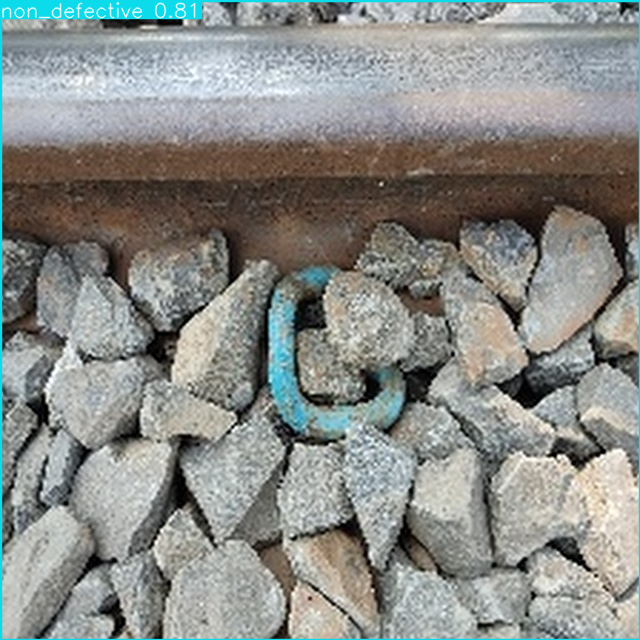

In [ ]:
# Step 19: IoU Calculation
import torch
import numpy as np
import cv2
import os

# Load YOLOv5 Model
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/drive/MyDrive/yolo_trained/runs/train/exp/weights/best.pt')
yolo_model.eval()

# Function to calculate IoU
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = box1_area + box2_area - intersection
    iou = intersection / union if union > 0 else 0
    return iou

# Function to convert YOLO format to [x1, y1, x2, y2]
def read_ground_truth_boxes(txt_path, image_shape):
    h, w = image_shape[:2]
    gt_boxes = []

    with open(txt_path, 'r') as f:
        for line in f:
            cls, x_center, y_center, width, height = map(float, line.strip().split())
            x1 = int((x_center - width / 2) * w)
            y1 = int((y_center - height / 2) * h)
            x2 = int((x_center + width / 2) * w)
            y2 = int((y_center + height / 2) * h)
            gt_boxes.append([x1, y1, x2, y2])

    return gt_boxes

image_path = '/content/drive/MyDrive/ML/yolo_dataset/images/valid/IMG_20201114_100450.jpg'
txt_path = "/content/drive/MyDrive/ML/yolo_dataset/labels/valid/IMG_20201114_100450.txt"

# Load Image and Ground Truth
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gt_boxes = read_ground_truth_boxes(txt_path, img.shape)

# Get Predictions from YOLO
results = yolo_model(image_path)
predicted_boxes = results.xyxy[0].cpu().numpy()[:, :4]  # [x1, y1, x2, y2]

# Calculate IoU
ious = []
for gt_box in gt_boxes:
    for pred_box in predicted_boxes:
        iou = calculate_iou(gt_box, pred_box)
        ious.append(iou)

# Display Results
if ious:
    print("IoU Scores:")
    for idx, iou in enumerate(ious):
        print(f"GT {idx // len(predicted_boxes)} vs Pred {idx % len(predicted_boxes)}: {iou:.4f}")
else:
    print("No predictions found.")

# Show detection image
results.print()
results.show()


In [ ]:
# Step 20: Display Training Results
import pandas as pd

# Load the CSV
metrics_path = 'runs/train/exp/results.csv'  # Update path if needed
df = pd.read_csv(metrics_path)

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Get the last epoch results
final_epoch = df.iloc[-1]

# Display Final Training Results
print(f"Final Training Results:\n")

# Check and print available metrics
print(f"Mean Average Precision (mAP): {final_epoch['metrics/mAP_0.5']:.4f}")
print(f"mAP50-95: {final_epoch['metrics/mAP_0.5:0.95']:.4f}")
print(f"Validation Precision: {final_epoch['metrics/precision']:.4f}")
print(f"Validation Recall: {final_epoch['metrics/recall']:.4f}")
print(f"Training Box Loss: {final_epoch['train/box_loss']:.4f}")
print(f"Validation Box Loss: {final_epoch['val/box_loss']:.4f}")


Final Training Results:

Mean Average Precision (mAP): 0.4672
mAP50-95: 0.4042
Validation Precision: 0.5373
Validation Recall: 0.5274
Training Box Loss: 0.0228
Validation Box Loss: 0.0681


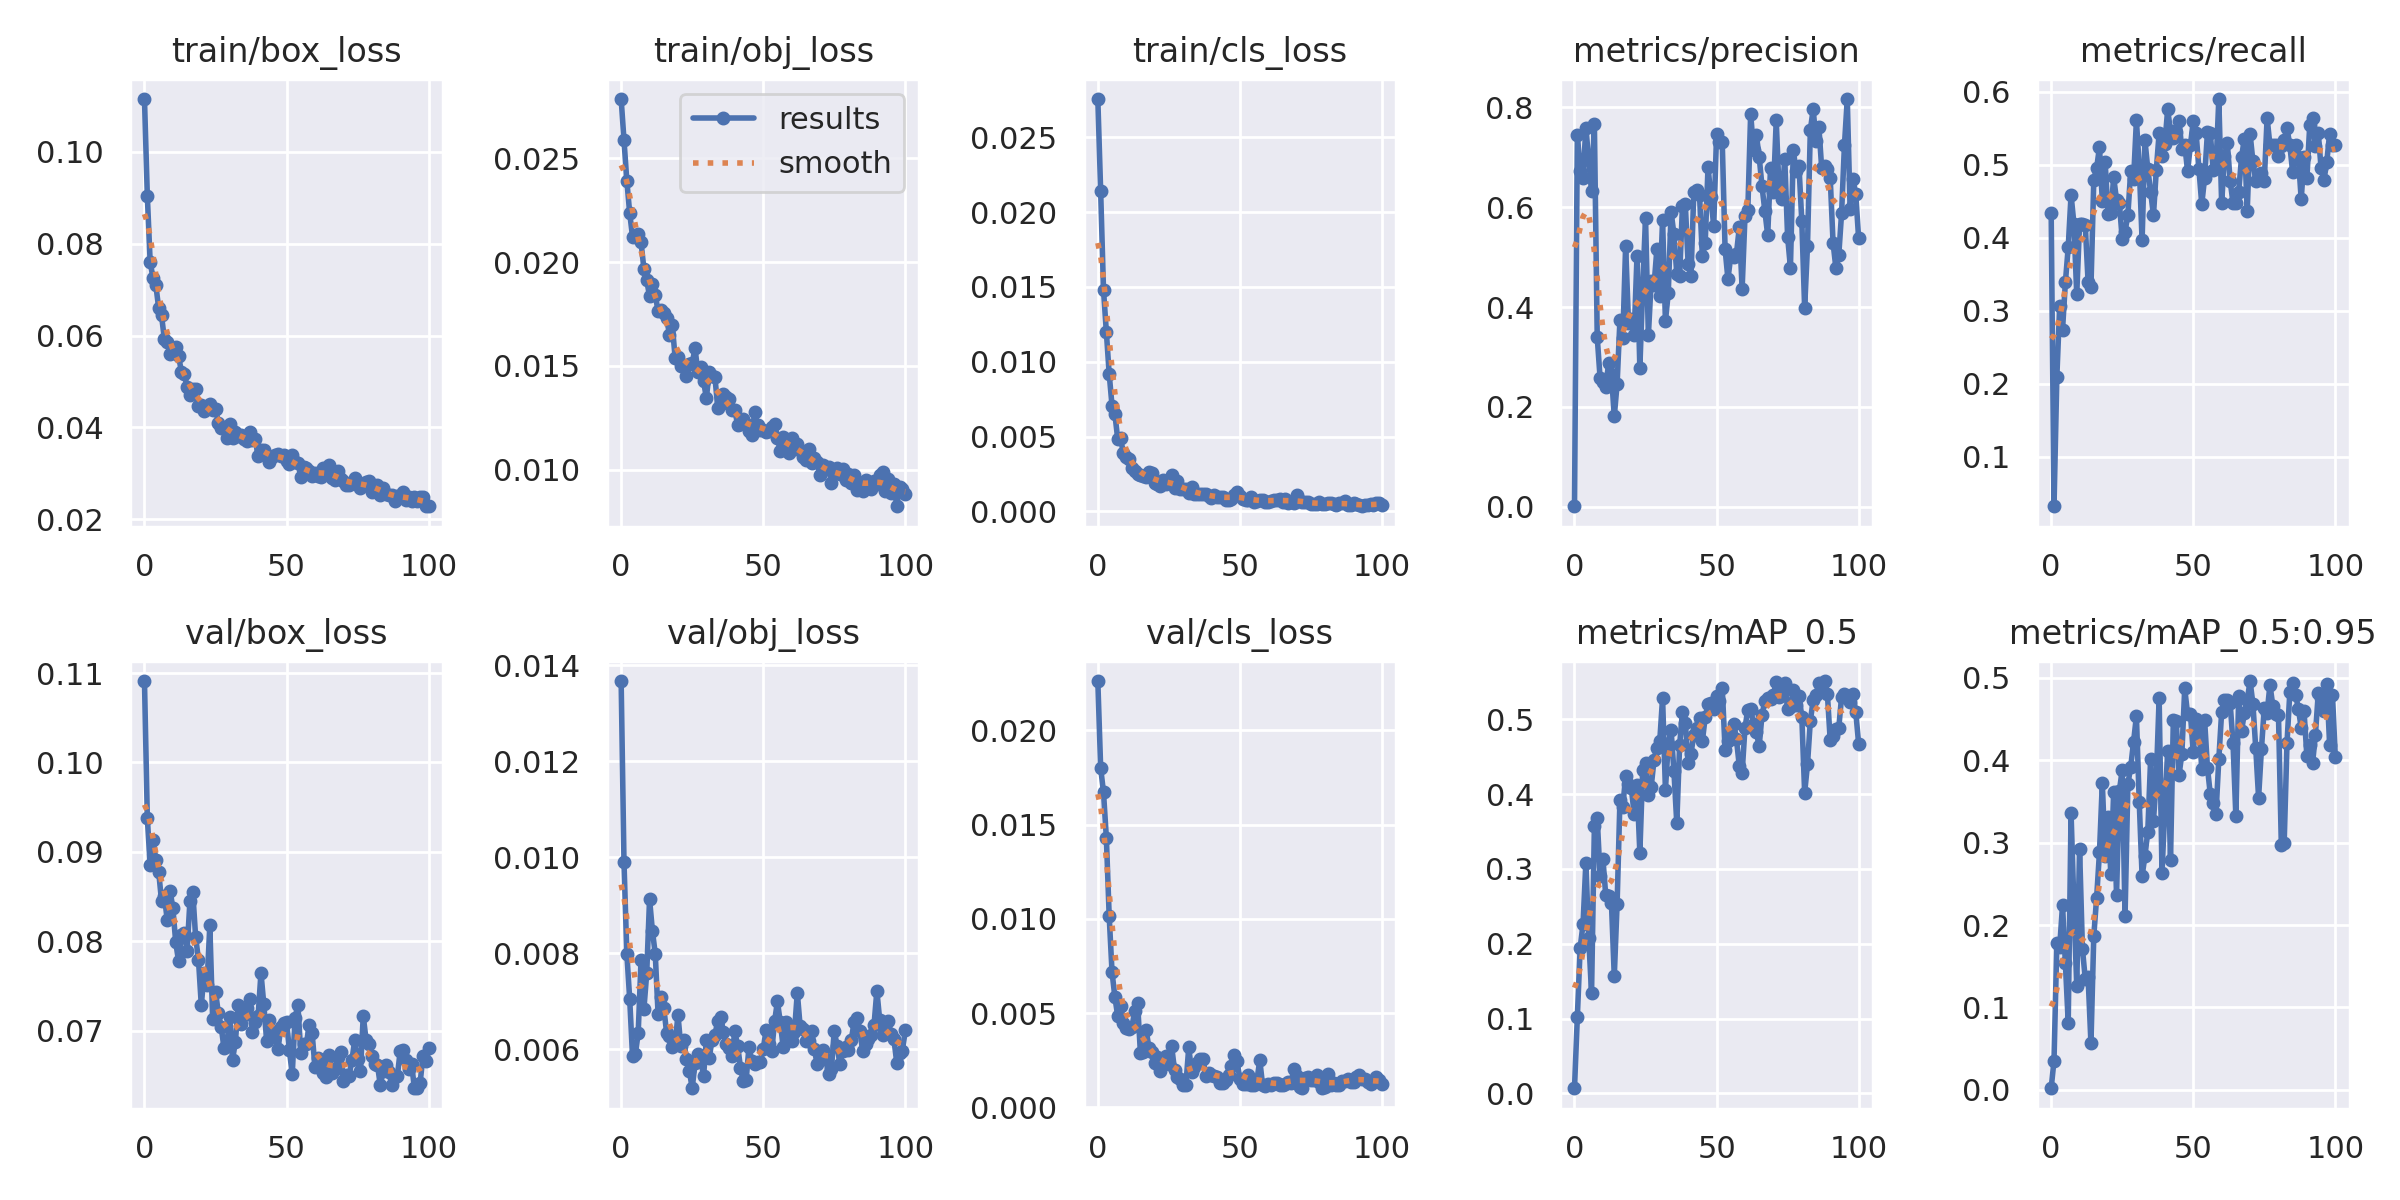

In [ ]:
# Step 21: Display Loss & Accuracy Graphs
from IPython.display import Image
Image(filename='runs/train/exp/results.png')  # Shows loss & accuracy graphs

In [ ]:
# Step 22: Perform Object Detection using YOLOv5
!python detect.py --weights runs/train/exp/weights/best.pt --img 640 --conf 0.5 --source /content/drive/MyDrive/ML/yolo_dataset/images/test/

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/ML/yolo_dataset/images/test/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-457-g84ef1e59 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/22 /content/drive/MyDrive/ML/yolo_dataset/images/test/IMG_20201114_100023.jpg: 640x640 1 non_defective, 11.5ms
image 2/22 /content/drive/MyDrive/ML/yolo_dataset/images/test/IMG_20201114_100159.jpg: 640x640 1 defective, 11.5ms
image 3/22 /content/drive/MyDrive/ML/yolo_dataset

In [ ]:
!cp -r /content/yolov5 /content/drive/MyDrive/yolo_trained/

In [ ]:
# Step 23: Save the model
import torch
torch.save(yolo_model, "/content/drive/MyDrive/best.pt")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
# Step 24: Load Trained YOLOv5 Model
import torch
model_path = '/content/drive/MyDrive/yolo_trained/yolov5/runs/train/exp/weights/best.pt'  # Update the path
yolo_model = torch.hub.load('ultralytics/yolov5', 'custom', path=model_path, trust_repo=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2026-1-18 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


Upload a railway track image:


Saving 2007.05.16_-_002_Broken_rail_weld_-_Flickr_-_faxepl.jpg to 2007.05.16_-_002_Broken_rail_weld_-_Flickr_-_faxepl.jpg


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:899: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


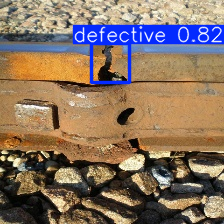

Severity Score: 0.0242
Risk Level: Low Risk


In [ ]:
# Step 25: Severity-based Risk Prediction using YOLOv5 Outputs

from google.colab import files
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

# ---- Upload image for risk prediction ----
print("Upload a railway track image:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# ---- Display uploaded image ----
img_disp = cv2.imread(image_path)
img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img_disp)
plt.title("Uploaded Railway Track Image")
plt.axis("off")
plt.show()

# ---- Severity score computation ----
def compute_severity_score(detections, img_shape):
    img_area = img_shape[0] * img_shape[1]
    score = 0.0
    for det in detections:
        x1, y1, x2, y2, conf, cls = det
        area = (x2 - x1) * (y2 - y1)
        score += (area / img_area) * conf
    return score * len(detections)

# ---- Severity → risk label ----
def severity_label(score):
    if score < 0.03:
        return 0   # Low
    elif score < 0.08:
        return 1   # Medium
    else:
        return 2   # High

risk_map = {0: "Low Risk", 1: "Medium Risk", 2: "High Risk"}

# ---- Run YOLO ----
results = yolo_model(image_path)
results.show()   # shows detection boxes

df = results.pandas().xyxy[0]

if 'defective' in df['name'].values:
    img_cv = cv2.imread(image_path)
    dets = df[df['name'] == 'defective'][
        ['xmin','ymin','xmax','ymax','confidence','class']
    ].values

    sev = compute_severity_score(dets, img_cv.shape)
    label = severity_label(sev)

    print("Severity Score:", round(sev, 4))
    print("Risk Level:", risk_map[label])
else:
    print("No defects detected → Low Risk")


Upload a railway track image:


Saving azer2003120026fbtr.jpg to azer2003120026fbtr (1).jpg


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:899: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


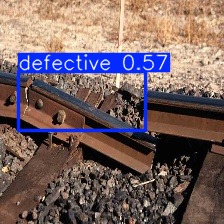

Severity Score: 0.0843
Risk Level: High Risk


In [ ]:
# Step 25: Severity-based Risk Prediction using YOLOv5 Outputs

from google.colab import files
import cv2
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

# ---- Upload image for risk prediction ----
print("Upload a railway track image:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# ---- Display uploaded image ----
img_disp = cv2.imread(image_path)
img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img_disp)
plt.title("Uploaded Railway Track Image")
plt.axis("off")
plt.show()

# ---- Severity score computation ----
def compute_severity_score(detections, img_shape):
    img_area = img_shape[0] * img_shape[1]
    score = 0.0
    for det in detections:
        x1, y1, x2, y2, conf, cls = det
        area = (x2 - x1) * (y2 - y1)
        score += (area / img_area) * conf
    return score * len(detections)

# ---- Severity → risk label ----
def severity_label(score):
    if score < 0.03:
        return 0   # Low
    elif score < 0.08:
        return 1   # Medium
    else:
        return 2   # High

risk_map = {0: "Low Risk", 1: "Medium Risk", 2: "High Risk"}

# ---- Run YOLO ----
results = yolo_model(image_path)
results.show()   # shows detection boxes

df = results.pandas().xyxy[0]

if 'defective' in df['name'].values:
    img_cv = cv2.imread(image_path)
    dets = df[df['name'] == 'defective'][
        ['xmin','ymin','xmax','ymax','confidence','class']
    ].values

    sev = compute_severity_score(dets, img_cv.shape)
    label = severity_label(sev)

    print("Severity Score:", round(sev, 4))
    print("Risk Level:", risk_map[label])
else:
    print("No defects detected → Low Risk")


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:899: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


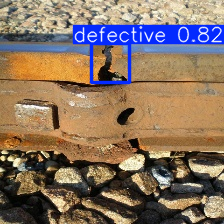


Severity Score: 0.0242
Final Risk Level: Low Risk


In [ ]:
# Step 26: YOLO Detection + Severity-based Risk Prediction

results = yolo_model(image_path)
results.show()

df = results.pandas().xyxy[0]
img_cv = cv2.imread(image_path)

severity_X, severity_y = [], []

if 'defective' in df['name'].values:
    defective_detections = df[df['name'] == 'defective'][
        ['xmin','ymin','xmax','ymax','confidence','class']
    ].values

    sev_score = compute_severity_score(defective_detections, img_cv.shape)
    sev_label = severity_label(sev_score)

    severity_X.append([sev_score])
    severity_y.append(sev_label)

    print(f"\nSeverity Score: {sev_score:.4f}")
    print(f"Final Risk Level: {risk_map[sev_label]}")
else:
    print("\nNo defects detected → Low Risk assumed")
    severity_X.append([0.0])
    severity_y.append(0)


In [ ]:
# Step 27: Random Forest vs XGBoost Risk Model Comparison (Severity-based)

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# -------- Random Forest --------
rf_model = RandomForestClassifier(
    n_estimators=50,
    random_state=42
)
rf_model.fit(severity_X, severity_y)
rf_pred = rf_model.predict(severity_X)

# -------- XGBoost (MULTICLASS FIX) --------
xgb_model = XGBClassifier(
    objective="multi:softmax",   # IMPORTANT
    num_class=3,                 # Low, Medium, High
    eval_metric="mlogloss",
    random_state=42
)
xgb_model.fit(severity_X, severity_y)
xgb_pred = xgb_model.predict(severity_X)

print("\nRisk Model Comparison:")
print("Random Forest Prediction:", risk_map[int(rf_pred[0])])
print("XGBoost Prediction:", risk_map[int(xgb_pred[0])])



Risk Model Comparison:
Random Forest Prediction: Low Risk
XGBoost Prediction: Low Risk


In [ ]:
# Step 28: Ablation Study (YOLO only vs ResNet+YOLO vs Full System)

from PIL import Image
import torchvision.transforms as transforms
import torch
import cv2

# ----- Transform for ResNet (Case 2) -----
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

def ablation_study(image_path):
    print("\nAblation Study")

    # ================= Case 1 =================
    results = yolo_model(image_path)
    df_case = results.pandas().xyxy[0]
    print("Case 1: YOLOv5 only → Defects detected:", len(df_case))

    # ================= Case 2 =================
    res_model.eval()
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        out = res_model(input_tensor)
        cls = out.argmax(1).item()

    class_names = ["defective", "non_defective"]
    print("Case 2: ResNet + YOLO (no risk) → Classification:",
          class_names[cls])

    # ================= Case 3 =================
    if 'defective' in df_case['name'].values:
        img_cv = cv2.imread(image_path)
        dets = df_case[df_case['name'] == 'defective'][
            ['xmin','ymin','xmax','ymax','confidence','class']
        ].values

        sev = compute_severity_score(dets, img_cv.shape)
        print("Case 3: Full system → Severity:",
              f"{sev:.4f}", "| Risk:", risk_map[severity_label(sev)])
    else:
        print("Case 3: Full system → No defects (Low Risk)")


ablation_study(image_path)



Ablation Study
Case 1: YOLOv5 only → Defects detected: 1
Case 2: ResNet + YOLO (no risk) → Classification: defective
Case 3: Full system → Severity: 0.0242 | Risk: Low Risk


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:899: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [ ]:
# Step 29: Robustness Testing (Blur, Noise, Low-Light)

blur = cv2.GaussianBlur(img_cv, (7,7), 0)
noise = np.clip(img_cv + np.random.normal(0,25,img_cv.shape), 0, 255).astype(np.uint8)
low_light = (img_cv * 0.5).astype(np.uint8)

cv2.imwrite("blur.jpg", blur)
cv2.imwrite("noise.jpg", noise)
cv2.imwrite("low_light.jpg", low_light)

for name, path in {
    "Original": image_path,
    "Blur": "blur.jpg",
    "Noise": "noise.jpg",
    "Low Light": "low_light.jpg"
}.items():
    print(f"\nRobustness Test → {name}")
    ablation_study(path)



Robustness Test → Original

Ablation Study
Case 1: YOLOv5 only → Defects detected: 1
Case 2: ResNet + YOLO (no risk) → Classification: defective
Case 3: Full system → Severity: 0.0242 | Risk: Low Risk

Robustness Test → Blur

Ablation Study
Case 1: YOLOv5 only → Defects detected: 1
Case 2: ResNet + YOLO (no risk) → Classification: defective
Case 3: Full system → Severity: 0.0180 | Risk: Low Risk

Robustness Test → Noise

Ablation Study


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:899: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:899: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Case 1: YOLOv5 only → Defects detected: 1
Case 2: ResNet + YOLO (no risk) → Classification: defective
Case 3: Full system → Severity: 0.0194 | Risk: Low Risk

Robustness Test → Low Light

Ablation Study
Case 1: YOLOv5 only → Defects detected: 1
Case 2: ResNet + YOLO (no risk) → Classification: defective
Case 3: Full system → Severity: 0.0222 | Risk: Low Risk


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:899: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:899: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [ ]:
# Step 30: Runtime and Memory Analysis

import time
import psutil
start_time = time.time()
_ = yolo_model(image_path)
end_time = time.time()

memory_usage = psutil.Process().memory_info().rss / (1024 ** 2)

print("\nSystem Performance:")
print(f"Inference Time: {end_time - start_time:.4f} seconds")
print(f"Memory Usage: {memory_usage:.2f} MB")



System Performance:
Inference Time: 0.0203 seconds
Memory Usage: 2284.84 MB


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:899: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
